<a href="https://colab.research.google.com/github/adalbertii/Modele-regresyjne/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.ensemble import IsolationForest # Outlier Detection
from keras.models import Sequential # Sequential Neural Network
from keras.layers import Dense
from keras.callbacks import EarlyStopping # Early Stopping Callback
from keras.optimizers import Adam # Optimizer
import keras_tuner
from tensorflow import keras


#from keras.kerastuner.tuners import RandomSearch # HyperParameter Tuning
import warnings
warnings.filterwarnings('ignore') # To ignore warnings.

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
y = train['SalePrice'].values
data = pd.concat([train,test],axis=0,sort=False)
data.drop(['SalePrice'],axis=1,inplace=True)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [8]:
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
NAN_col = list(missing_values.to_dict().keys())
missing_values_data = pd.DataFrame(missing_values)
missing_values_data.reset_index(level=0, inplace=True)
missing_values_data.columns = ['Feature','Number of Missing Values']
missing_values_data['Percentage of Missing Values'] = (100.0*missing_values_data['Number of Missing Values'])/len(data)
missing_values_data

,Feature,Number of Missing Values,Percentage of Missing Values
0,PoolQC,2909,99.657417
1,MiscFeature,2814,96.402878
2,Alley,2721,93.216855
3,Fence,2348,80.438506
4,FireplaceQu,1420,48.646797
5,LotFrontage,486,16.649538
6,GarageFinish,159,5.447071
7,GarageQual,159,5.447071
8,GarageCond,159,5.447071
9,GarageYrBlt,159,5.447071


In [9]:
data['BsmtFinSF1'].fillna(0, inplace=True)
data['BsmtFinSF2'].fillna(0, inplace=True)
data['TotalBsmtSF'].fillna(0, inplace=True)
data['BsmtUnfSF'].fillna(0, inplace=True)
data['Electrical'].fillna('FuseA',inplace = True)
data['KitchenQual'].fillna('TA',inplace=True)
data['LotFrontage'].fillna(data.groupby('1stFlrSF')['LotFrontage'].transform('mean'),inplace=True)
data['LotFrontage'].interpolate(method='linear',inplace=True)
data['MasVnrArea'].fillna(data.groupby('MasVnrType')['MasVnrArea'].transform('mean'),inplace=True)
data['MasVnrArea'].interpolate(method='linear',inplace=True)

In [10]:
for col in NAN_col:
    data_type = data[col].dtype
    if data_type == 'object':
        data[col].fillna('NA',inplace=True)
    else:
        data[col].fillna(data[col].mean(),inplace=True)

In [11]:
data['Total_Square_Feet'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF'])

data['Total_Bath'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

data['Total_Porch_Area'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

data['SqFtPerRoom'] = data['GrLivArea'] / (data['TotRmsAbvGrd'] + data['FullBath'] + data['HalfBath'] + data['KitchenAbvGr'])

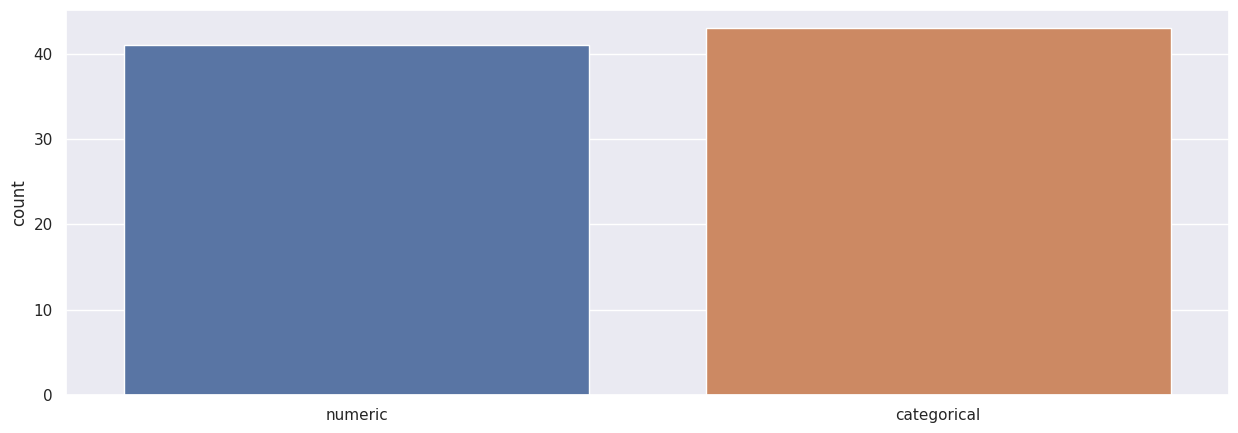

In [12]:
column_data_type = []
for col in data.columns:
    data_type = data[col].dtype
    if data[col].dtype in ['int64','float64']:
        column_data_type.append('numeric')
    else:
        column_data_type.append('categorical')
plt.figure(figsize=(15,5))
sns.countplot(x=column_data_type)
plt.show()

In [13]:
data = pd.get_dummies(data)

In [14]:
train = data[:1460].copy()
test = data[1460:].copy()
train['SalePrice'] = y

<Axes: >

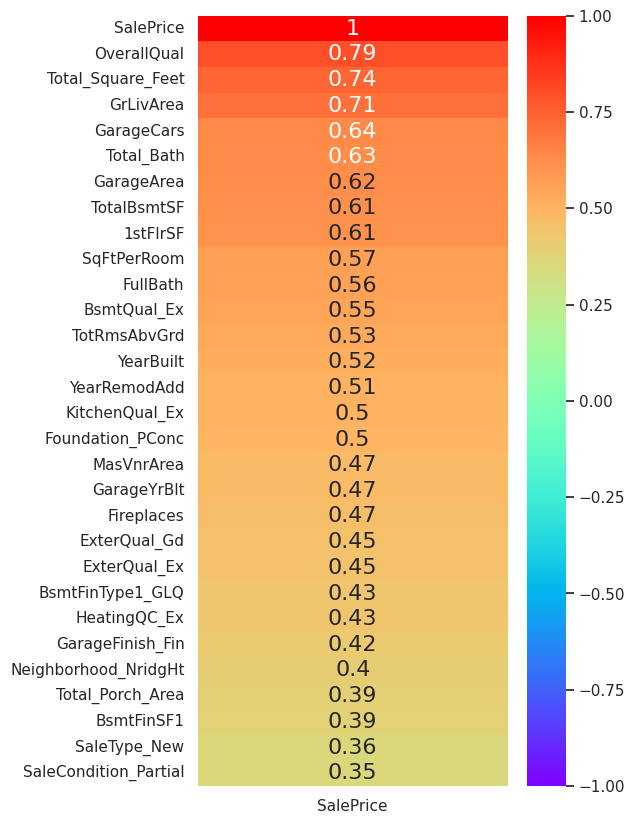

In [15]:
top_features = train.corr()[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)

In [16]:
def plot_data(col, discrete=False):
    if discrete:
        fig, ax = plt.subplots(1,2,figsize=(14,6))
        sns.stripplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.countplot(train[col], ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.scatterplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.distplot(train[col], kde=False, ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')

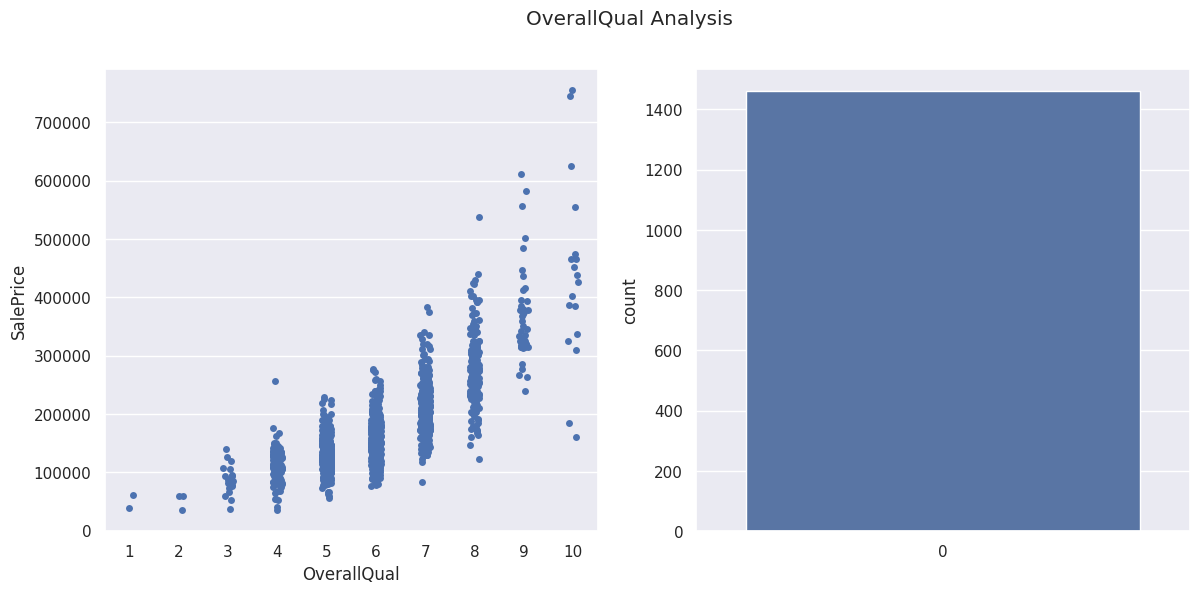

In [17]:
plot_data('OverallQual',True)

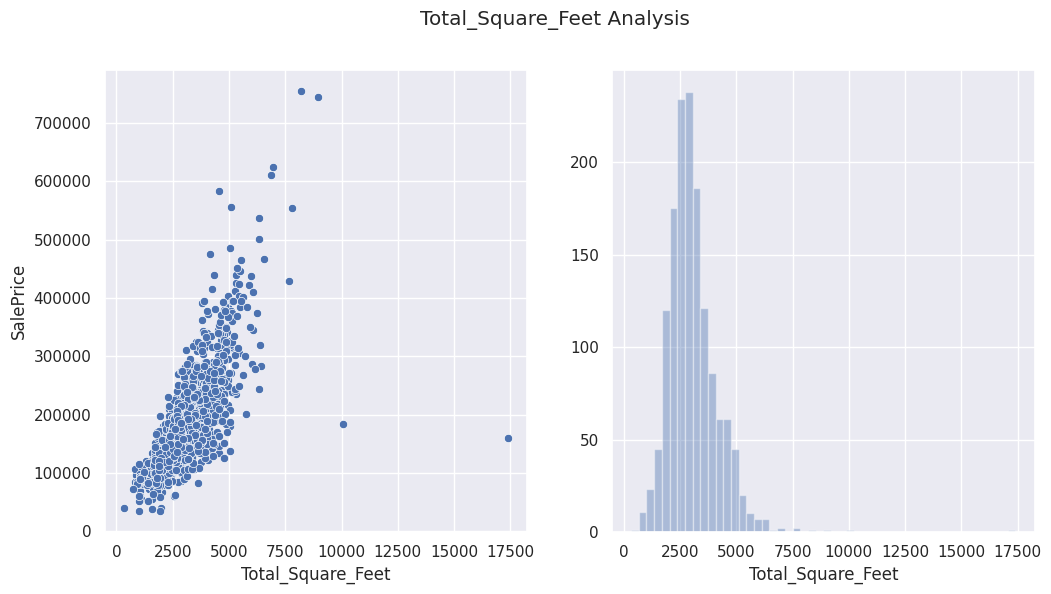

In [18]:
plot_data('Total_Square_Feet')

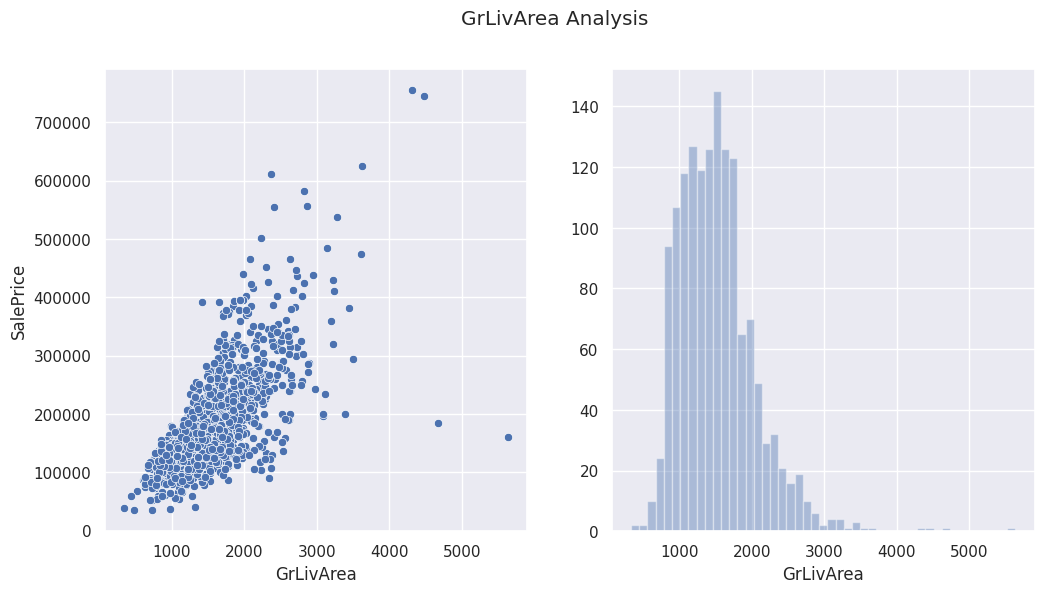

In [19]:
plot_data('GrLivArea')

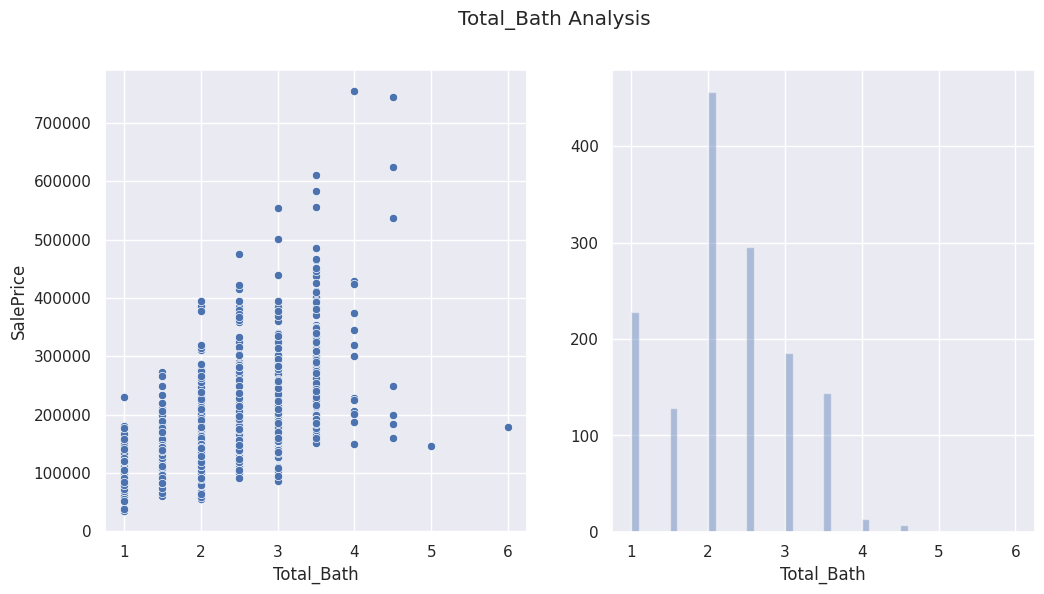

In [20]:
plot_data('Total_Bath')

In [21]:
train = train.drop(train[(train['Total_Bath'] > 4) & (train['SalePrice'] < 200000)].index)

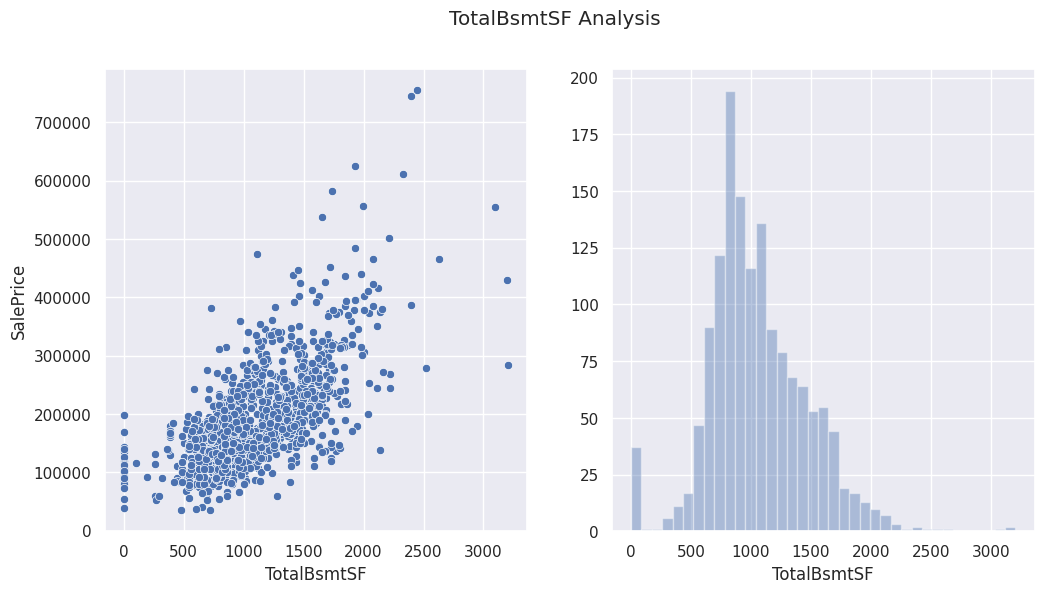

In [22]:
plot_data('TotalBsmtSF')

In [23]:
train = train.drop(train[(train['TotalBsmtSF'] > 3000) & (train['SalePrice'] < 400000)].index)

In [24]:
train.reset_index() # To reset the index

,index,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0,1,60,65.0,8450,7,5,2003,2003,196.0,...,0,0,1,0,0,0,0,1,0,208500
1,1,2,20,80.0,9600,6,8,1976,1976,0.0,...,0,0,1,0,0,0,0,1,0,181500
2,2,3,60,68.0,11250,7,5,2001,2002,162.0,...,0,0,1,0,0,0,0,1,0,223500
3,3,4,70,60.0,9550,7,5,1915,1970,0.0,...,0,0,1,1,0,0,0,0,0,140000
4,4,5,60,84.0,14260,8,5,2000,2000,350.0,...,0,0,1,0,0,0,0,1,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,1455,1456,60,62.0,7917,6,5,1999,2000,0.0,...,0,0,1,0,0,0,0,1,0,175000
1451,1456,1457,20,85.0,13175,6,6,1978,1988,119.0,...,0,0,1,0,0,0,0,1,0,210000
1452,1457,1458,70,66.0,9042,7,9,1941,2006,0.0,...,0,0,1,0,0,0,0,1,0,266500
1453,1458,1459,20,68.0,9717,5,6,1950,1996,0.0,...,0,0,1,0,0,0,0,1,0,142125


In [25]:
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 18
Number of rows without outliers: 1437


In [26]:
X = train.copy()
X.drop(['SalePrice'],axis=1,inplace=True) # Dropped the y feature
y = train['SalePrice'].values

In [27]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model

In [31]:
from kerastuner.tuners import RandomSearch # HyperParameter Tuning

In [32]:
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='model_dir',
    project_name='House_Price_Prediction')



In [ ]:
tuner.search

In [34]:
tuner.search(X[1100:],y[1100:],batch_size=128,epochs=200,validation_data=(X[:1100],y[:1100]))

Trial 10 Complete [00h 01m 56s]
val_mse: 1380636714.6666667

Best val_mse So Far: 1230420821.3333333
Total elapsed time: 00h 19m 23s


In [35]:
model = tuner.get_best_models(1)[0]

In [39]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(320, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(352, activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mse')
    return model
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 320)               100800    
                                                                 
 dense_6 (Dense)             (None, 384)               123264    
                                                                 
 dense_7 (Dense)             (None, 352)               135520    
                                                                 
 dense_8 (Dense)             (None, 448)               158144    
                                                                 
 dense_9 (Dense)             (None, 160)               71840     
                                                                 
 dense_10 (Dense)            (None, 160)               25760     
                                                                 
 dense_11 (Dense)            (None, 32)               

Epoch 1/1000
11/11 [==============================] - 2s 43ms/step - loss: 39430889472.0000 - val_loss: 36838174720.0000
Epoch 2/1000
11/11 [==============================] - 0s 23ms/step - loss: 39063773184.0000 - val_loss: 36309045248.0000
Epoch 3/1000
11/11 [==============================] - 0s 24ms/step - loss: 38203342848.0000 - val_loss: 34972164096.0000
Epoch 4/1000
11/11 [==============================] - 0s 24ms/step - loss: 36121227264.0000 - val_loss: 31737839616.0000
Epoch 5/1000
11/11 [==============================] - 0s 22ms/step - loss: 31274358784.0000 - val_loss: 24596058112.0000
Epoch 6/1000
11/11 [==============================] - 0s 20ms/step - loss: 22047727616.0000 - val_loss: 12588669952.0000
Epoch 7/1000
11/11 [==============================] - 0s 22ms/step - loss: 13490681856.0000 - val_loss: 5773394432.0000
Epoch 8/1000
11/11 [==============================] - 0s 24ms/step - loss: 11596752896.0000 - val_loss: 5179091968.0000
Epoch 9/1000
11/11 [==============

<Axes: >

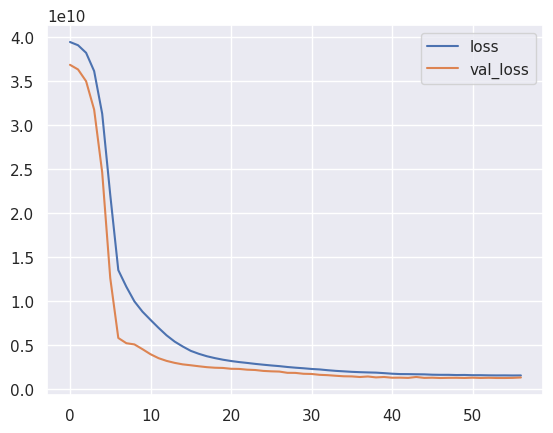

In [40]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=X,y=y,
          validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[early_stop])
losses = pd.DataFrame(model.history.history)
losses.plot()

In [42]:
from sklearn import preprocessing

In [48]:
scaler = preprocessing.StandardScaler().fit(test)


In [50]:
X_test=test

In [54]:
#X_test = scale.transform(test) # Scaling the testing data.
result = model.predict(X_test) # Prediction using model
result = pd.DataFrame(result,columns=['SalePrice']) # Dataframe
result['Id'] = test['Id'] # Adding ID to our result dataframe.
result = result[['Id','SalePrice']]
result.head()

46/46 [==============================] - 0s 4ms/step


,Id,SalePrice
0,1461,135036.578125
1,1462,166838.687500
2,1463,201720.062500
3,1464,197812.234375
4,1465,169035.187500


In [52]:
test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_NA,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0


In [60]:
X.shape

(1437, 314)